In [1]:
import os
import sys
import defopt
import pickle
import numpy as np
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit
from scipy.stats import wilcoxon
import random
import itertools

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # save text as text not outlines
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

import cottage_analysis as cott
from cottage_analysis.depth_analysis.filepath.generate_filepaths import *
from cottage_analysis.imaging.common import find_frames
from cottage_analysis.imaging.common import imaging_loggers_formatting as format_loggers
from cottage_analysis.stimulus_structure import sphere_structure as vis_stim_structure
from cottage_analysis.depth_analysis.plotting.plotting_utils import *
from cottage_analysis.depth_analysis.plotting.basic_vis_plots import *
from cottage_analysis.depth_analysis.depth_preprocess.process_params import *
from cottage_analysis.depth_analysis.depth_preprocess.process_trace import *

In [2]:
def get_trace_arrs(roi, dffs, depth_list, stim_dict,
                                            mode='sort_by_depth', protocol='fix_length',
                                            blank_period=5, frame_rate=15):
    # Trace array of dFF
    trace_arr, _ = create_trace_arr_per_roi(roi, dffs, depth_list, stim_dict,
                                            mode='sort_by_depth', protocol='fix_length',
                                            blank_period=blank_period, frame_rate=frame_rate)
    # trace_arr_mean = np.nanmean(trace_arr, axis=1)
    trace_arr_noblank, _ = create_trace_arr_per_roi(roi, dffs, depth_list, stim_dict,
                                                    mode='sort_by_depth', protocol='fix_length',
                                                    blank_period=0, frame_rate=frame_rate)
    # trace_arr_noblank_mean = np.nanmean(trace_arr_noblank, axis=1)
    trace_arr_blank, _ = create_trace_arr_per_roi(roi, dffs, depth_list, stim_dict,
                                                  mode='sort_by_depth', protocol='fix_length',
                                                  isStim=False, blank_period=0,
                                                  frame_rate=frame_rate)
    return trace_arr_noblank, trace_arr_blank


def train_test_split_trials(p_test, xarr1, xarr2, yarr):
    test_trials_no = random.sample(range(xarr1.shape[1]),int(xarr1.shape[1]*p_test))
    train_trials_no = list(set(range(xarr1.shape[1]))-set(test_trials_no))
    
    X_train1 = xarr1[:,train_trials_no,:]
    X_test1 = xarr1[:,test_trials_no,:]
    
    # trace with all rois
    X_train2 = xarr2[:,:,train_trials_no,:]
    X_test2 = xarr2[:,:,test_trials_no,:]
    
    y_train = yarr[:,train_trials_no]
    y_test = yarr[:,test_trials_no]

    return X_train1, X_test1, X_train2, X_test2, y_train, y_test

    
# Seperate data based on running speed bins
def separate_data_into_bins(arr, bin_arr, bins, shape):
    if arr.ndim > 1:
        # it's a trace array
        _,_,bin_no = scipy.stats.binned_statistic(x=bin_arr, values=arr[0], statistic='mean', bins=bins, range=None)
        arr_all_bins = []
        for i in range(np.nanmin(bin_no),np.nanmax(bin_no)+1): 
            arr_all_bins.append((arr.reshape(shape))[:,np.where(bin_no==i)[0]])
    else:
        # it's a param array
        _,_,bin_no = scipy.stats.binned_statistic(x=bin_arr, values=arr, statistic='mean', bins=bins, range=None)
        arr_all_bins = []
        for i in range(np.nanmin(bin_no),np.nanmax(bin_no)+1): 
            arr_all_bins.append((arr)[np.where(bin_no==i)[0]])
    return arr_all_bins


def train_classifier(X_train, X_test, X_val, y_train, y_test, y_val, param_grid, class_labels, kernel='linear'):
    # Train the SVM classifier and tune hyperparameters
    best_acc=0
    best_params = {'C': param_grid['C'][0], 'gamma': param_grid['gamma'][0]}
    for C in param_grid['C']:
        for gamma in param_grid['gamma']:
            clf = SVC(C=C, gamma=gamma, kernel=kernel)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            
            if acc > best_acc:
                best_acc = acc
                best_params = {'C': C, 'gamma': gamma}
            print(f'C{C}, gamma{gamma}', flush=True)

    # Train the final classifier on the best hyperparameters
    clf = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=kernel)
    clf.fit(X_train, y_train)
    # Evaluate the accuracy of the classifier
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    conmat = confusion_matrix(y_test, y_pred, labels=class_labels)

    # print("Accuracy: {:.2f}%".format(acc * 100))
    return acc, conmat, clf


def downsample_2darray(arr, window, mode='average'):
    mode = 'average'
    end =  window * int(arr.shape[1]/window)
    if mode=='average':
        arr_crop = arr[:,:end].reshape(arr.shape[0], -1, window)
        arr_mean = np.mean(arr_crop,axis=2).reshape(arr.shape[0],-1)
    return arr_mean
    
    
def rolling_average_2darray(arr, axis, window):
     result = pd.DataFrame(arr).rolling(window,axis=axis, min_periods=1).mean(skipna=True).values
     return result
 
 
def plot_confusion_matrix(conmat, fontsize_dict):
    plt.imshow(conmat, interpolation='nearest', cmap='Blues')
    fmt = 'd'
    thresh = conmat.max() / 2.
    for i, j in itertools.product(range(conmat.shape[0]), range(conmat.shape[1])):
        plt.text(j, i, str(int(conmat[i, j])),
                horizontalalignment="center",
                color="white" if conmat[i, j] > thresh else "black", fontsize=fontsize_dict['text'])
    plt.xlabel('Predicted depth class',fontsize=fontsize_dict['xlabel'])
    plt.ylabel('True depth class',fontsize=fontsize_dict['ylabel'])
    
    
MIN_SIGMA=0.5

def gaussian_func(x, a, x0, log_sigma,b):
    a = a
    sigma = np.exp(log_sigma)+MIN_SIGMA
    return (a * np.exp(-(x - x0) ** 2) / (2 * sigma ** 2))+b

def plot_depth_tuning_curve(trace_arr_noblank,
                            depth_list,
                            plot_rows, plot_cols, fontsize_dict,
                            grid=True,
                            this_depth=None,
                           gaussian_fit=False, popt = [],
                           title='Depth tuning', ylabel='dF/F', xlabel='Depth (cm)', linewidth=1):
    # --- Plot 4 (0,3): Depth tuning curve ---
    trace_arr_noblank_cp = trace_arr_noblank.copy()
#     trace_arr_noblank_cp[speed_arr_noblank < speed_thr_cal] = np.nan
    trace_arr_mean_eachtrial = np.nanmean(trace_arr_noblank_cp, axis=2)
    CI_lows = np.zeros(len(depth_list))
    CI_highs = np.zeros(len(depth_list))
    for idepth in range(len(depth_list)):
        CI_lows[idepth], CI_highs[idepth] = get_confidence_interval(
            trace_arr_mean_eachtrial[idepth, :],
            mean_arr=np.nanmean(trace_arr_mean_eachtrial, axis=1)[idepth].reshape(-1, 1))
        
    if gaussian_fit:
        if (this_depth == None) or (this_depth!=len(depth_list)): # we can't plot the tuning curve for non-depth-selective neurons
            plot_line_with_error(arr=np.nanmean(trace_arr_mean_eachtrial, axis=1), CI_low=CI_lows,
                                 CI_high=CI_highs, linecolor='b', fontsize_dict=fontsize_dict, linewidth=linewidth)

            trace_arr_mean_eachtrial = np.nanmean(trace_arr_noblank, axis=2)
            x = np.log(np.repeat(np.array(depth_list), trace_arr_mean_eachtrial.shape[1]))
            roi_number = np.where(depth_neurons == roi)[0][0]
            
            plt.plot(np.linspace(0, len(depth_list) - 1, 100),
                     gaussian_func(np.linspace(np.log(depth_list[0]*100), np.log(depth_list[-1]*100), 100), *popt), 'gray', linewidth=3)
            plt.xticks(np.arange(len(depth_list)), (np.array(depth_list) * 100).astype('int'),
                       fontsize=fontsize_dict['xticks'])
            plt.yticks(fontsize=fontsize_dict['yticks'])
            plt.ylabel(ylabel, fontsize=fontsize_dict['title'])
            plt.xlabel(xlabel, fontsize=fontsize_dict['xlabel'])
            plt.title(title, fontsize=fontsize_dict['ylabel'])
            plot_frame_off()
    else:
        plot_line_with_error(arr=np.nanmean(trace_arr_mean_eachtrial, axis=1), CI_low=CI_lows,
                             CI_high=CI_highs, linecolor='royalblue', fontsize_dict=fontsize_dict, linewidth=linewidth)
        plt.xticks(np.arange(len(depth_list)), (np.array(depth_list) * 100).astype('int'),
                   fontsize=fontsize_dict['xticks'])
        plt.ylabel(ylabel, fontsize=fontsize_dict['ylabel'])
        plt.xlabel(xlabel, fontsize=fontsize_dict['xlabel'])
        plt.title(title, fontsize=fontsize_dict['title'])
        plot_frame_off()
        
        
def plot_line_with_error(arr, CI_low, CI_high, linecolor, fontsize_dict, 
                         label=None, marker='-', markersize=None, xarr=[], xlabel=None, ylabel=None, 
                         title_on=False, title=None, suffix=None, linewidth=0.5, rasterized=False):
    if len(xarr) == 0:
        plt.plot(arr, marker, c = linecolor, linewidth=linewidth, label=label, alpha = 1, markersize=markersize, rasterized=rasterized)
        plt.fill_between(np.arange(len(arr)), CI_low, CI_high, color=linecolor, alpha=0.3, edgecolor=None, rasterized=rasterized)
    else:
        plt.plot(xarr, arr, marker, c = linecolor, linewidth=linewidth, label=label, alpha = 1, markersize=markersize, rasterized=rasterized)
        plt.fill_between(xarr, CI_low, CI_high, color=linecolor, alpha=0.3, edgecolor=None, rasterized=rasterized)
    plt.xlabel(xlabel, fontsize=fontsize_dict['xlabel'])
    plt.ylabel(ylabel, fontsize=fontsize_dict['ylabel'])
    if title_on:
        plt.title(title+' '+suffix, fontsize=fontsize_dict['title'])
    else:
        plt.title(suffix, fontsize=fontsize_dict['title'])
        
        
# get rid of nan values from trace arr and the corresponding rs/depth
def remove_nan(xarr, arr1, arr2, shape):
    nanidx = np.isnan(xarr[0])
    arr1 = arr1[~nanidx]
    arr2 = arr2[~nanidx]
    xarr = xarr[~np.isnan(xarr)].reshape(shape)

    return xarr, arr1, arr2

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---------Process protocol SpheresPermTubeReward/1---------
---STEP 1: Load files...--- 



/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:160: DeprecationWarning: flexilims_session will become mandatory
  sess_children = get_session_children(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:165: DeprecationWarning: flexilims_session will become mandatory
  recording_entries, recording_path = get_recording_entries(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/depth_analysis/filepath/generate_filepaths.py:90: UserWarning: all_protocol_recording_entries not given, assume only one recording for protocol SpheresPermTubeReward in this session.
             The last recording that matches this protocoll will be returned.
  warn(


---STEP 1 FINISHED.--- 

---STEP 2: Process params...--- 

---STEP 3: Decoding depth...--- 

Downsampling data finished. 

Fitting classifier on all data... 



<ipython-input-20-464f54b75160>:168: RuntimeWarning: divide by zero encountered in log10
  ] = [np.log10(rs_train).flatten(),
<ipython-input-20-464f54b75160>:169: RuntimeWarning: divide by zero encountered in log10
  np.log10(rs_test).flatten(),
<ipython-input-20-464f54b75160>:170: RuntimeWarning: divide by zero encountered in log10
  np.log10(rs_val).flatten(),


Fitting classifier on RS bins... 

C0.1, gamma1
C0.1, gamma0.1
C0.1, gamma0.01
C1, gamma1
C1, gamma0.1
C1, gamma0.01
C10, gamma1
C10, gamma0.1
C10, gamma0.01
RS bin 0
RS bin 1
RS bin 2
RS bin 3
RS bin 4
RS bin 5


<ipython-input-20-464f54b75160>:300: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plot_rows = bin_number//plot_cols + int(np.bool(bin_number%plot_cols))


NameError: name 'fontsize_dict' is not defined

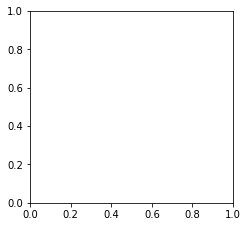

In [20]:

project = 'hey2_3d-vision_foodres_20220101'
mouse = 'PZAH8.2f'
session = 'S20230210'
protocols = ['SpheresPermTubeReward']

# ----- SETUPS -----
frame_rate = 15
speed_thr_cal = 0.2  # m/s, threshold for running speed when calculating depth neurons
speed_thr = 0.01  #m/s

# ----- PATHS -----
flexilims_session = flz.get_flexilims_session(project_id=project)
sess_children = get_session_children(project=project, mouse=mouse, session=session, flexilims_session=flexilims_session)
# if len(sess_children[sess_children.name.str.contains('Playback')])>0:
#     protocols = ['SpheresPermTubeReward','SpheresPermTubeRewardPlayback']
# else:
#     protocols = ['SpheresPermTubeReward']
root = Path(flz.PARAMETERS["data_root"]["processed"])

for protocol in protocols:
    print(f'---------Process protocol {protocol}/{len(protocols)}---------', flush=True)
    print('---STEP 1: Load files...---', '\n', flush=True)
    # ----- STEP1: Generate file path -----
    session_analysis_folder_original = root/project/'Analysis'/mouse/session/protocols[0]
    session_protocol_folder = root/project/mouse/session/protocol
    session_analysis_folder = root/project/'Analysis'/mouse/session/protocol
    (
    _,
    _,
    _,
    suite2p_folder,
    _,
    ) = generate_file_folders(
        project=project,
        mouse=mouse,
        session=session,
        protocol=protocol,
        all_protocol_recording_entries=None, 
        recording_no=0, 
        flexilims_session=None
    )
    
    save_prefix = 'plane0/depth_decoder'
    save_folder = session_analysis_folder/save_prefix
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    # Load suite2p files
    ops = np.load(suite2p_folder/'ops.npy', allow_pickle=True)
    ops = ops.item()
    iscell = np.load(suite2p_folder/'iscell.npy', allow_pickle=True)[:, 0]
    
    # All_rois
    which_rois = (np.arange(iscell.shape[0]))[iscell.astype('bool')]

    with open(session_protocol_folder/"plane0/img_VS_all.pickle", "rb") as handle:
        img_VS_all = pickle.load(handle)
    with open(session_protocol_folder/"plane0/stim_dict_all.pickle", "rb") as handle:
        stim_dict_all = pickle.load(handle)
    dffs_ast_all = np.load(session_protocol_folder/"plane0/dffs_ast_all.npy")

    depth_list = img_VS_all["Depth"].unique()
    depth_list = np.round(depth_list, 2)
    depth_list = depth_list[~np.isnan(depth_list)].tolist()
    depth_list.remove(-99.99)
    depth_list.sort()
    if len(depth_list)==5:
        depth_list=[0.06, 0.19, 0.6, 1.9, 6]
    
    cmap = cm.cool.reversed()
    line_colors = []
    norm = matplotlib.colors.Normalize(vmin=np.log(min(depth_list)), vmax=np.log(max(depth_list)))
    for depth in depth_list:
        rgba_color = cmap(norm(np.log(depth)),bytes=True)
        rgba_color = tuple(it/255 for it in rgba_color)
        line_colors.append(rgba_color)
            
    print('---STEP 1 FINISHED.---', '\n', flush=True)
    
    
    # PARAMS PROCESSING
    print('---STEP 2: Process params...---', '\n', flush=True)
    # Speed array
    # Running speed is thresholded with a small threshold to get rid of non-zero values (default threshold 0.01)
    speeds = img_VS_all.MouseZ.diff() / img_VS_all.HarpTime.diff()  # with no playback. EyeZ and MouseZ should be the same.
    speeds[0] = 0
    speeds = thr(speeds, 0)
    speed_arr_noblank,_ = create_speed_arr(speeds, depth_list, stim_dict_all, mode='sort_by_depth', protocol='fix_length', blank_period=0, frame_rate=frame_rate)
    speed_arr =  speed_arr_noblank
    

    # # OF (Unit: rad/s)
    # if 'Playback' in protocol:
    #     speeds_eye = img_VS_all.EyeZ.diff() / img_VS_all.HarpTime.diff()  # EyeZ is how the perspective of animal moves
    #     speeds_eye[0] = 0
    #     # speeds_eye = thr(speeds_eye, speed_thr)
    #     speed_eye_arr_noblank,_ = create_speed_arr(speeds_eye, depth_list, stim_dict_all, mode='sort_by_depth', protocol='fix_length', blank_period=0, frame_rate=frame_rate)

    #     optics = calculate_OF(rs=speeds_eye, img_VS=img_VS_all, mode='no_RF')

    # else:
    #     optics = calculate_OF(rs=speeds, img_VS=img_VS_all, mode='no_RF')

    # of_arr, _ = create_speed_arr(optics, depth_list, stim_dict_all, mode='sort_by_depth',
    #                     protocol='fix_length', blank_period=3)
    # of_arr_mean = np.nanmean(of_arr, axis=1)
    # of_arr_noblank, _ = create_speed_arr(optics, depth_list, stim_dict_all, mode='sort_by_depth',
    #                                     protocol='fix_length', blank_period=0)
    # of_arr_noblank_mean = np.nanmean(of_arr_noblank, axis=1)
    # of_arr_blank, _ = create_speed_arr(optics, depth_list, stim_dict_all, mode='sort_by_depth',
    #                                 protocol='fix_length', isStim=False, blank_period=0)
    
    # Transform speed into cm/s, optic flow into degrees/s
    speed_arr_noblank = speed_arr_noblank*100
    # of_arr_noblank = np.degrees(of_arr_noblank)
    
    # PARAMS PROCESSING
    print('---STEP 3: Decoding depth...---', '\n', flush=True)
    # Rolling average and downsample of running speeds
    window_period = 0.5
    frame_rate = 15
    window = int(window_period*frame_rate)
    speed_arr_smoothed = rolling_average_2darray(arr=speed_arr_noblank.reshape(-1,speed_arr_noblank.shape[2]), axis=1, window=window).reshape(speed_arr_noblank.shape)
    speed_arr_downsam = downsample_2darray(arr=speed_arr_smoothed.reshape(-1,speed_arr_smoothed.shape[2]), window=window, mode='average').reshape(speed_arr_smoothed.shape[0],speed_arr_smoothed.shape[1],-1)

    # concat all cells dffs
    all_trace_downsam = np.zeros((len(which_rois),speed_arr_downsam.shape[0],speed_arr_downsam.shape[1],speed_arr_downsam.shape[2]))

    for iroi, roi in enumerate(which_rois):
        # Load trace_arr
        trace_arr_noblank, _ = get_trace_arrs(roi=roi, dffs=dffs_ast_all, 
                                                        depth_list=depth_list, stim_dict=stim_dict_all,
                                    mode='sort_by_depth', protocol='fix_length',
                                    blank_period=0, frame_rate=frame_rate)
        # Downsample trace
        trace_arr_downsam = downsample_2darray(arr=trace_arr_noblank.reshape(-1,trace_arr_noblank.shape[2]), window=window, mode='average').reshape(trace_arr_noblank.shape[0],trace_arr_noblank.shape[1],-1)
        all_trace_downsam[iroi, :] = trace_arr_downsam
    print('Downsampling data finished.', '\n', flush=True)

        
    
    # Classifier on all data
    print('Fitting classifier on all data...', '\n', flush=True)
    # train test split
    depth_labels = np.repeat(np.repeat(np.arange(len(depth_list)),speed_arr_downsam.shape[1]),speed_arr_downsam.shape[2]).reshape(len(depth_list),speed_arr_downsam.shape[1],speed_arr_downsam.shape[2])
    speed_min = 1
    speed_max= 150

    rs_train, rs_test, trace_train, trace_test, depth_train, depth_test = train_test_split_trials(p_test=0.4, 
                                                                                                xarr1=speed_arr_downsam, 
                                                                                                xarr2=all_trace_downsam,
                                                                                                yarr=depth_labels)
    rs_test, rs_val, trace_test, trace_val, depth_test, depth_val = train_test_split_trials(p_test=0.5, 
                                                                                            xarr1=rs_test, 
                                                                                            xarr2=trace_test,
                                                                                            yarr=depth_test)

    # Log all data and flatten array
    [rs_train, 
        rs_test, 
        rs_val,
        trace_train, 
        trace_test, 
        trace_val,
        depth_train, 
        depth_test, 
        depth_val,
        ] = [np.log10(rs_train).flatten(), 
            np.log10(rs_test).flatten(), 
            np.log10(rs_val).flatten(),
            (trace_train).reshape(len(which_rois),-1), 
            (trace_test).reshape(len(which_rois),-1), 
            (trace_val).reshape(len(which_rois),-1),
            (depth_train).flatten(), 
            (depth_test).flatten(), 
            (depth_val).flatten()]
        

    nanidx = np.isnan(trace_train[0])
    depth_train = depth_train[~nanidx]
    trace_train = trace_train[~np.isnan(trace_train)].reshape(len(which_rois),-1)
    nanidx = np.isnan(trace_test[0])
    depth_test = depth_test[~nanidx]
    trace_test= trace_test[~np.isnan(trace_test)].reshape(len(which_rois),-1)
    nanidx = np.isnan(trace_val[0])
    depth_val = depth_val[~nanidx]
    trace_val= trace_val[~np.isnan(trace_val)].reshape(len(which_rois),-1)

        
    param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]} 
    # acc_same, conmat_same, clf = train_classifier(X_train=trace_train.T, 
    #                 X_test=trace_test.T, 
    #                 X_val = trace_val.T,
    #                 y_train=depth_train, 
    #                 y_test=depth_test, 
    #                 y_val=depth_val, 
    #                 param_grid=param_grid,
    #                 class_labels=np.arange(len(depth_list)))
    
    # fontsize_dict = {
    #     'xlabel':10,
    #     'ylabel':10,
    #     'xticks':10,
    #     'yticks':10,
    #     'title':10,
    #     'legend':10,
    #     'text':10
    #     }
    # plt.figure()
    # plot_confusion_matrix(conmat=conmat_same, fontsize_dict=fontsize_dict)
    # plt.title(f'Acc: {np.round(acc_same,2)}')
    # plt.tight_layout(pad=1)
    # plt.savefig(save_folder/'conmat_all_data.pdf')
    
    # acc_same = np.array([acc_same])
    # conmat_same = np.array([conmat_same])
    # np.save(save_folder/'acc_all_data.npy', acc_same)
    # np.save(save_folder/'conmat_all_data.npy', conmat_same)
    
    # print('Classifier on all data finished', '\n', flush=True)
    
    
    # Classifier on all bins of RS
    print('Fitting classifier on RS bins...', '\n', flush=True)
    # Train and test on 50% of data, validate on 10% of data, test on 40% of data with splitting into different running bins
    depth_labels = np.repeat(np.repeat(np.arange(len(depth_list)),speed_arr_downsam.shape[1]),speed_arr_downsam.shape[2]).reshape(len(depth_list),speed_arr_downsam.shape[1],speed_arr_downsam.shape[2])
    bin_number=5
    # speed_min = 1
    # speed_max= 150
    # speed_arr_downsam_log = np.log10(speed_arr_downsam)
    rs_classifier, rs_rest, trace_classifier, trace_rest, depth_classifier, depth_rest = train_test_split_trials(p_test=0.4, 
                                                                                                xarr1=speed_arr_downsam, 
                                                                                                xarr2=all_trace_downsam,
                                                                                                yarr=depth_labels)
    rs_classifier_train_test, rs_val, trace_classifier_train_test, trace_val, depth_classifier_train_test, depth_val = train_test_split_trials(p_test=0.1, 
                                                                                            xarr1=rs_classifier, 
                                                                                            xarr2=trace_classifier,
                                                                                            yarr=depth_classifier)
    rs_train, rs_classifier_test, trace_train, trace_classifier_test, depth_train, depth_classifier_test = train_test_split_trials(p_test=0.1, 
                                                                                            xarr1=rs_classifier_train_test, 
                                                                                            xarr2=trace_classifier_train_test,
                                                                                            yarr=depth_classifier_train_test)


    trace_rest, depth_rest, rs_rest = remove_nan(xarr=trace_rest, arr1=depth_rest, arr2=rs_rest, shape=(len(which_rois),-1))
    trace_train, depth_train, rs_train = remove_nan(xarr=trace_train, arr1=depth_train, arr2=rs_train, shape=(len(which_rois),-1))
    trace_val, depth_val, rs_val = remove_nan(xarr=trace_val, arr1=depth_val, arr2=rs_val, shape=(len(which_rois),-1))
    trace_classifier_test, depth_classifier_test, rs_classifier_test = remove_nan(xarr=trace_classifier_test, arr1=depth_classifier_test, arr2=rs_classifier_test, shape=(len(which_rois),-1))

    log_range = {
        'rs_bin_log_min':0,
        'rs_bin_log_max':2.5,
        'rs_bin_num':6,
        'of_bin_log_min':-1.5,
        'of_bin_log_max':3.5,
        'of_bin_num':11,
        'log_base':10
        }
    bin_number = log_range['rs_bin_num']
    speed_min = np.power(log_range['log_base'],log_range['rs_bin_log_min'])
    speed_max = np.power(log_range['log_base'], log_range['rs_bin_log_max'])
    rs_bins = np.geomspace(speed_min, speed_max, log_range['rs_bin_num'])
    rs_bins = np.insert(rs_bins, 0, 0)
    trace_all_bins = separate_data_into_bins(arr=trace_rest, bin_arr=rs_rest, bins=rs_bins, shape=(len(which_rois),-1))
    rs_all_bins = separate_data_into_bins(arr=rs_rest, bin_arr=rs_rest, bins=rs_bins, shape=(len(which_rois),-1))
    depth_all_bins = separate_data_into_bins(arr=depth_rest, bin_arr=rs_rest, bins=rs_bins, shape=(len(which_rois),-1))
    
    
    # Train classifier with all bins
    param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]} 
    all_accs = []
    all_conmats = []
    acc_same, conmat_same, clf = train_classifier(X_train=trace_train.T, 
                    X_test=trace_classifier_test.T, 
                    X_val = trace_val.T,
                    y_train=depth_train, 
                    y_test=depth_classifier_test, 
                    y_val=depth_val, 
                    param_grid=param_grid,
                    class_labels=np.arange(len(depth_list)))
    
    # if the mouse is not running that fast
    test_bins = bin_number 
    if (len(rs_all_bins) == bin_number-1) or (len(rs_all_bins[-1])<5):
        test_bins = bin_number - 1

    # Evaluate the accuracy of the classifier
    for i in range(test_bins):
        y_pred = clf.predict(trace_all_bins[i].T)
        acc = accuracy_score(depth_all_bins[i], y_pred)
        conmat = confusion_matrix(depth_all_bins[i], y_pred, labels=np.arange(len(depth_list)))
        all_accs.append(acc)
        all_conmats.append(conmat)
        print(f'RS bin {i}', flush=True)  
    if test_bins != bin_number:
        all_accs.append(np.nan)
        all_conmats.append(np.full((conmat.shape),np.nan))
              
        
    plot_cols = 2
    plot_rows = bin_number//plot_cols + int(np.bool(bin_number%plot_cols))
    plt.figure(figsize=(plot_cols*4, plot_rows*4))
    for i in range(bin_number):
        plt.subplot(plot_rows, plot_cols, i+1)
        plot_confusion_matrix(conmat=all_conmats[i], fontsize_dict=fontsize_dict)
        plt.title(f'bin {i}, acc: {np.round(all_accs[i],2)}')
    plt.tight_layout(pad=1)
    plt.savefig(save_folder/'conmat_all_bins.pdf')
    
    if test_bins != bin_number:
        all_accs = np.array(all_accs)
        all_conmats = np.array(all_conmats)
        all_accs[-1] = np.nan
        all_conmats[-1] = np.full((conmat.shape),np.nan)
    np.save(save_folder/'accs_all_bins.npy', all_accs)
    np.save(save_folder/'conmats_all_bins.npy', all_conmats)

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RS bin 0
RS bin 1
RS bin 2
RS bin 3
RS bin 4


<ipython-input-27-db3070e65071>:30: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plot_rows = bin_number//plot_cols + int(np.bool(bin_number%plot_cols))


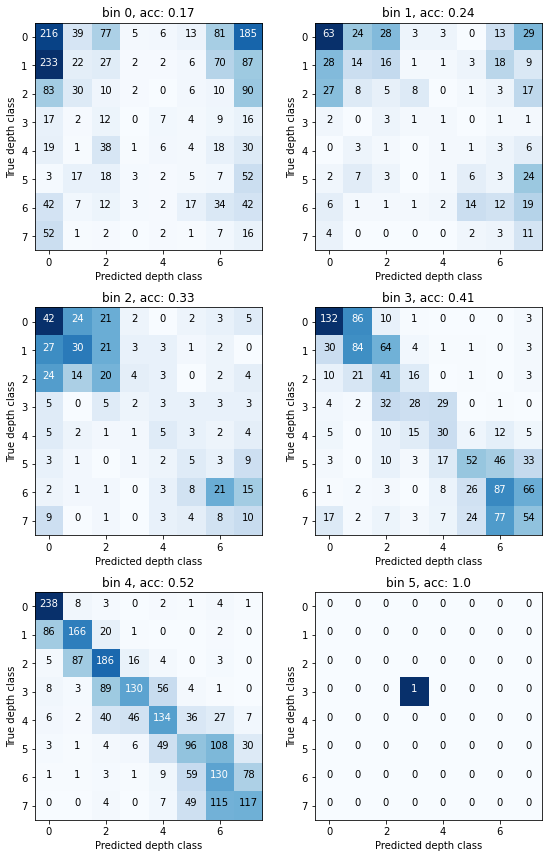

In [27]:
fontsize_dict = {
    'xlabel':10,
    'ylabel':10,
    'xticks':10,
    'yticks':10,
    'title':10,
    'legend':10,
    'text':10
}

# if the mouse is not running that fast
test_bins = bin_number 
if (len(rs_all_bins) == bin_number-1) or (len(rs_all_bins[-1])<5):
    test_bins = bin_number - 1

# Evaluate the accuracy of the classifier
for i in range(test_bins):
    y_pred = clf.predict(trace_all_bins[i].T)
    acc = accuracy_score(depth_all_bins[i], y_pred)
    conmat = confusion_matrix(depth_all_bins[i], y_pred, labels=np.arange(len(depth_list)))
    all_accs.append(acc)
    all_conmats.append(conmat)
    print(f'RS bin {i}', flush=True)  
if test_bins != bin_number:
    all_accs.append(np.nan)
    all_conmats.append(np.full((conmat.shape),np.nan))
            
    
plot_cols = 2
plot_rows = bin_number//plot_cols + int(np.bool(bin_number%plot_cols))
plt.figure(figsize=(plot_cols*4, plot_rows*4))
for i in range(bin_number):
    plt.subplot(plot_rows, plot_cols, i+1)
    plot_confusion_matrix(conmat=all_conmats[i], fontsize_dict=fontsize_dict)
    plt.title(f'bin {i}, acc: {np.round(all_accs[i],2)}')
plt.tight_layout(pad=1)
plt.savefig(save_folder/'conmat_all_bins.pdf')

if test_bins != bin_number:
    all_accs = np.array(all_accs)
    all_conmats = np.array(all_conmats)
    all_accs[-1] = np.nan
    all_conmats[-1] = np.full((conmat.shape),np.nan)

In [30]:
all_conmats[-2]

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[238.,   8.,   3.,   0.,   2.,   1.,   4.,   1.],
       [ 86., 166.,  20.,   1.,   0.,   0.,   2.,   0.],
       [  5.,  87., 186.,  16.,   4.,   0.,   3.,   0.],
       [  8.,   3.,  89., 130.,  56.,   4.,   1.,   0.],
       [  6.,   2.,  40.,  46., 134.,  36.,  27.,   7.],
       [  3.,   1.,   4.,   6.,  49.,  96., 108.,  30.],
       [  1.,   1.,   3.,   1.,   9.,  59., 130.,  78.],
       [  0.,   0.,   4.,   0.,   7.,  49., 115., 117.]])

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RS bin 0
RS bin 1
RS bin 2
RS bin 3
RS bin 4
RS bin 5


<ipython-input-24-6b6ff10d93ff>:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plot_rows = bin_number//plot_cols + int(np.bool(bin_number%plot_cols))


NameError: name 'fontsize_dict' is not defined

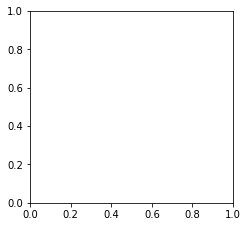

In [24]:
# Evaluate the accuracy of the classifier
for i in range(test_bins):
    y_pred = clf.predict(trace_all_bins[i].T)
    acc = accuracy_score(depth_all_bins[i], y_pred)
    conmat = confusion_matrix(depth_all_bins[i], y_pred, labels=np.arange(len(depth_list)))
    all_accs.append(acc)
    all_conmats.append(conmat)
    print(f'RS bin {i}', flush=True)  
if test_bins != bin_number:
    all_accs.append(np.nan)
    all_conmats.append(np.full((conmat.shape),np.nan))
            
    
plot_cols = 2
plot_rows = bin_number//plot_cols + int(np.bool(bin_number%plot_cols))
plt.figure(figsize=(plot_cols*4, plot_rows*4))
for i in range(bin_number):
    plt.subplot(plot_rows, plot_cols, i+1)
    plot_confusion_matrix(conmat=all_conmats[i], fontsize_dict=fontsize_dict)
    plt.title(f'bin {i}, acc: {np.round(all_accs[i],2)}')
plt.tight_layout(pad=1)
plt.savefig(save_folder/'conmat_all_bins.pdf')

if test_bins != bin_number:
    all_accs = np.array(all_accs)
    all_conmats = np.array(all_conmats)
    all_accs[-1] = np.nan
    all_conmats[-1] = np.full((conmat.shape),np.nan)

In [21]:
all_accs

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0.1685761047463175,
 0.24145299145299146,
 0.32608695652173914,
 0.41033925686591277,
 0.5220235499345836,
 1.0]

In [23]:
all_conmats[-1]

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [18]:
np.nanmax(speed_arr_downsam)

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


103.72072185994159

In [19]:
rs_bins

/camp/home/hey2/.conda/envs/2p_analysis_cottage/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([  0.        ,   1.        ,   3.16227766,  10.        ,
        31.6227766 , 100.        , 316.22776602])

In [ ]:
# Load openloop data (speed_arr, of_arr)
# ----- SETUPS -----
project = 'hey2_3d-vision_foodres_20220101'
mouse = 'PZAH6.4b'
session = 'S20220524'
protocol = 'SpheresPermTubeRewardPlayback'

rawdata_root = '/camp/lab/znamenskiyp/data/instruments/raw_data/projects/'
root = '/camp/lab/znamenskiyp/home/shared/projects/'
depth_list = [0.06, 0.19, 0.6, 1.9, 6]
choose_trials = 50
frame_rate = 15
# speed_thr_cal = 0.2  # m/s, threshold for running speed when calculating depth neurons
# speed_thr = 0.01  #m/s

cmap = cm.cool.reversed()
line_colors = []
norm = matplotlib.colors.Normalize(vmin=np.log(min(depth_list)), vmax=np.log(max(depth_list)))
for depth in depth_list:
    rgba_color = cmap(norm(np.log(depth)),bytes=True)
    rgba_color = tuple(it/255 for it in rgba_color)
    line_colors.append(rgba_color)
    
# ----- STEP1: Generate file path -----
print('---START STEP 1---', '\n', 'Getting data filepaths...', flush=True)
rawdata_folder, protocol_folder, analysis_folder, suite2p_folder, trace_folder = generate_file_folders(
    project=project,
    mouse=mouse,
    session=session,
    protocol=protocol,
    rawdata_root=rawdata_root,
    root=root)
print(rawdata_folder, protocol_folder, analysis_folder, suite2p_folder, trace_folder, flush=True)

if 'Playback' in protocol:
    rawdata_folder_closeloop, protocol_folder_closeloop, analysis_folder_closeloop, suite2p_folder_closeloop, trace_folder_closeloop = generate_file_folders(project=project,
                                                                                                    mouse=mouse,
                                                                                                    session=session,
                                                                                                    protocol=protocol.replace('Playback',''),
                                                                                                    rawdata_root=rawdata_root,
                                                                                                    root=root)
    print(rawdata_folder_closeloop, protocol_folder_closeloop, analysis_folder_closeloop, suite2p_folder_closeloop, trace_folder_closeloop, flush=True)
    assert(os.path.exists(analysis_folder_closeloop/'plane0/'))

print('---STEP 1 FINISHED.---', '\n', flush=True)



# ----- STEP2: Load files -----
print('---START STEP 2---', '\n', 'Load files...', flush=True)
# Load suite2p files
ops = np.load(suite2p_folder/'ops.npy', allow_pickle=True)
ops = ops.item()
iscell = np.load(suite2p_folder/'iscell.npy', allow_pickle=True)[:, 0]
F = np.load(trace_folder/'F.npy', allow_pickle=True)
Fast = np.load(trace_folder/'Fast.npy', allow_pickle=True)
# Fneu = np.load(trace_folder + 'Fneu.npy', allow_pickle=True)
# spks = np.load(trace_folder + 'spks.npy', allow_pickle=True)

# All_rois
which_rois = (np.arange(F.shape[0]))[iscell.astype('bool')]

# dffs_ast
dffs = np.load(trace_folder/'dffs_ast.npy')


# Load stim structure file
with open(protocol_folder/'img_VS.pickle', 'rb') as handle:
    img_VS = pickle.load(handle)
if os.path.exists(protocol_folder/'stim_dict.pickle'):
    with open(protocol_folder/'stim_dict.pickle', 'rb') as handle:
        stim_dict = pickle.load(handle)
else:
    stim_dict = vis_stim_structure.create_stim_dict(depth_list=depth_list, img_VS=img_VS, choose_trials=choose_trials)


# Load depth neurons
if 'Playback' in protocol:
    depth_neurons = np.load(analysis_folder_closeloop/'plane0/depth_neurons.npy')
    max_depths = np.load(analysis_folder_closeloop/'plane0/max_depths_index.npy')
else:
    depth_neurons = np.load(analysis_folder/'plane0/depth_neurons.npy')
    max_depths = np.load(analysis_folder/'plane0/max_depths_index.npy')

print('---STEP 2 FINISHED.---', '\n', flush=True)

# ----- STEP3: Plotting -----
print('---START STEP 3---', '\n', 'Plotting...', flush=True)
# SETUP
dff_plot_max = 3
blank_period = 5
fontsize = 20
speed_bins = 15
frame_rate = 15
speed_thr = 0.01

# PARAMS PROCESSING
# Speed array
# Running speed is thresholded with a small threshold to get rid of non-zero values (default threshold 0.01)
speeds = img_VS.MouseZ.diff() / img_VS.HarpTime.diff()  # with no playback. EyeZ and MouseZ should be the same.
speeds[0] = 0
speeds = thr(speeds, speed_thr)
# speed_arr, _ = create_speed_arr(speeds, depth_list, stim_dict, mode='sort_by_depth', protocol='fix_length',
#                                 blank_period=0, frame_rate=frame_rate)
# speed_arr_mean = np.nanmean(speed_arr,axis=1)
speed_arr_noblank,_ = create_speed_arr(speeds, depth_list, stim_dict, mode='sort_by_depth', protocol='fix_length', blank_period=0, frame_rate=frame_rate)
speed_arr =  speed_arr_noblank

# speed_arr_noblank_mean = np.nanmean(speed_arr_noblank,axis=1)
# speed_arr_blank,_ = create_speed_arr(speeds, depth_list, stim_dict, mode='sort_by_depth', protocol='fix_length', isStim=False, blank_period=0, frame_rate=frame_rate)
# frame_num_pertrial_max = speed_arr_noblank.shape[2]
# total_trials = speed_arr_noblank.shape[1]

# OF (Unit: rad/s)
if 'Playback' in protocol:
    speeds_eye = img_VS.EyeZ.diff() / img_VS.HarpTime.diff()  # EyeZ is how the perspective of animal moves
    speeds_eye[0] = 0
    speeds_eye = thr(speeds_eye, speed_thr)
    speed_eye_arr_noblank,_ = create_speed_arr(speeds_eye, depth_list, stim_dict, mode='sort_by_depth', protocol='fix_length', blank_period=0, frame_rate=frame_rate)

    optics = calculate_OF(rs=speeds_eye, img_VS=img_VS, mode='no_RF')

else:
    optics = calculate_OF(rs=speeds, img_VS=img_VS, mode='no_RF')

of_arr, _ = create_speed_arr(optics, depth_list, stim_dict, mode='sort_by_depth',
                    protocol='fix_length', blank_period=blank_period)
of_arr_mean = np.nanmean(of_arr, axis=1)
of_arr_noblank, _ = create_speed_arr(optics, depth_list, stim_dict, mode='sort_by_depth',
                                    protocol='fix_length', blank_period=0)
of_arr_noblank_mean = np.nanmean(of_arr_noblank, axis=1)
of_arr_blank, _ = create_speed_arr(optics, depth_list, stim_dict, mode='sort_by_depth',
                                protocol='fix_length', isStim=False, blank_period=0)


# Transform speed into cm/s, optic flow into degrees/s
speed_arr_noblank = speed_arr_noblank*100

of_arr_noblank = np.degrees(of_arr_noblank)


In [ ]:
# Rolling average and downsample of running speeds
window_period = 0.5
frame_rate = 15
window = int(window_period*frame_rate)
speed_arr_smoothed = rolling_average_2darray(arr=speed_arr_noblank.reshape(-1,speed_arr_noblank.shape[2]), axis=1, window=window).reshape(speed_arr_noblank.shape)
speed_arr_downsam = downsample_2darray(arr=speed_arr_smoothed.reshape(-1,speed_arr_smoothed.shape[2]), window=window, mode='average').reshape(speed_arr_smoothed.shape[0],speed_arr_smoothed.shape[1],-1)

# concat all cells dffs
all_trace_downsam = np.zeros((len(which_rois),speed_arr_downsam.shape[0],speed_arr_downsam.shape[1],speed_arr_downsam.shape[2]))

for iroi, roi in enumerate(which_rois):
    
    # Load trace_arr
    trace_arr_noblank, _ = get_trace_arrs(roi=roi, dffs=dffs, 
                                                    depth_list=depth_list, stim_dict=stim_dict,
                                mode='sort_by_depth', protocol='fix_length',
                                blank_period=0, frame_rate=frame_rate)
    # Downsample trace
    trace_arr_downsam = downsample_2darray(arr=trace_arr_noblank.reshape(-1,trace_arr_noblank.shape[2]), window=window, mode='average').reshape(trace_arr_noblank.shape[0],trace_arr_noblank.shape[1],-1)
    all_trace_downsam[iroi, :] = trace_arr_downsam

In [ ]:
# Train and test on all data
# train test split
depth_labels = np.repeat(np.repeat(np.arange(len(depth_list)),speed_arr_downsam.shape[1]),speed_arr_downsam.shape[2]).reshape(len(depth_list),speed_arr_downsam.shape[1],speed_arr_downsam.shape[2])
bin_number=10
speed_min = 1
speed_max= 150

rs_train, rs_test, trace_train, trace_test, depth_train, depth_test = train_test_split_trials(p_test=0.4, 
                                                                                            xarr1=speed_arr_downsam, 
                                                                                            xarr2=all_trace_downsam,
                                                                                            yarr=depth_labels)
rs_test, rs_val, trace_test, trace_val, depth_test, depth_val = train_test_split_trials(p_test=0.5, 
                                                                                        xarr1=rs_test, 
                                                                                        xarr2=trace_test,
                                                                                        yarr=depth_test)

# Log all data and flatten array
[rs_train, 
    rs_test, 
    rs_val,
    trace_train, 
    trace_test, 
    trace_val,
    depth_train, 
    depth_test, 
    depth_val,
    ] = [np.log10(rs_train).flatten(), 
        np.log10(rs_test).flatten(), 
        np.log10(rs_val).flatten(),
        (trace_train).reshape(len(which_rois),-1), 
        (trace_test).reshape(len(which_rois),-1), 
        (trace_val).reshape(len(which_rois),-1),
        (depth_train).flatten(), 
        (depth_test).flatten(), 
        (depth_val).flatten()]
    

nanidx = np.isnan(trace_train[0])
depth_train = depth_train[~nanidx]
trace_train = trace_train[~np.isnan(trace_train)].reshape(len(which_rois),-1)
nanidx = np.isnan(trace_test[0])
depth_test = depth_test[~nanidx]
trace_test= trace_test[~np.isnan(trace_test)].reshape(len(which_rois),-1)
nanidx = np.isnan(trace_val[0])
depth_val = depth_val[~nanidx]
trace_val= trace_val[~np.isnan(trace_val)].reshape(len(which_rois),-1)

    
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]} 
acc_same, conmat_same, clf = train_classifier(X_train=trace_train.T, 
                X_test=trace_test.T, 
                X_val = trace_val.T,
                y_train=depth_train, 
                y_test=depth_test, 
                y_val=depth_val, 
                param_grid=param_grid,
                class_labels=np.arange(len(depth_list)))

fontsize_dict = {
    'xlabel':20,
    'ylabel':20,
    'xticks':20,
    'yticks':20,
    'title':20,
    'legend':15,
    'text':15
    }
plot_confusion_matrix(conmat=conmat_same, fontsize_dict=fontsize_dict)
acc_same

In [ ]:
# Train and test on 50% of data, validate on 10% of data, test on 40% of data with splitting into different running bins
depth_labels = np.repeat(np.repeat(np.arange(len(depth_list)),speed_arr_downsam.shape[1]),speed_arr_downsam.shape[2]).reshape(len(depth_list),speed_arr_downsam.shape[1],speed_arr_downsam.shape[2])
bin_number=10
speed_min = 1
speed_max= 150
speed_arr_downsam_log = np.log10(speed_arr_downsam)
rs_classifier, rs_rest, trace_classifier, trace_rest, depth_classifier, depth_rest = train_test_split_trials(p_test=0.4, 
                                                                                            xarr1=speed_arr_downsam_log, 
                                                                                            xarr2=all_trace_downsam,
                                                                                            yarr=depth_labels)
rs_classifier_train_test, rs_val, trace_classifier_train_test, trace_val, depth_classifier_train_test, depth_val = train_test_split_trials(p_test=0.1, 
                                                                                        xarr1=rs_classifier, 
                                                                                        xarr2=trace_classifier,
                                                                                        yarr=depth_classifier)
rs_train, rs_classifier_test, trace_train, trace_classifier_test, depth_train, depth_classifier_test = train_test_split_trials(p_test=0.1, 
                                                                                        xarr1=rs_classifier_train_test, 
                                                                                        xarr2=trace_classifier_train_test,
                                                                                        yarr=depth_classifier_train_test)


bin_number=10
trace_rest, depth_rest, rs_rest = remove_nan(xarr=trace_rest, arr1=depth_rest, arr2=rs_rest, shape=(len(which_rois),-1))
trace_train, depth_train, rs_train = remove_nan(xarr=trace_train, arr1=depth_train, arr2=rs_train, shape=(len(which_rois),-1))
trace_val, depth_val, rs_val = remove_nan(xarr=trace_val, arr1=depth_val, arr2=rs_val, shape=(len(which_rois),-1))
trace_classifier_test, depth_classifier_test, rs_classifier_test = remove_nan(xarr=trace_classifier_test, arr1=depth_classifier_test, arr2=rs_classifier_test, shape=(len(which_rois),-1))

rs_bins = np.linspace(np.nanmin(speed_arr_downsam_log),np.nanmax(speed_arr_downsam_log),bin_number+1)
trace_all_bins = separate_data_into_bins(arr=trace_rest, bin_arr=rs_rest, bins=rs_bins, shape=(len(which_rois),-1))
rs_all_bins = separate_data_into_bins(arr=rs_rest, bin_arr=rs_rest, bins=rs_bins, shape=(len(which_rois),-1))
depth_all_bins = separate_data_into_bins(arr=depth_rest, bin_arr=rs_rest, bins=rs_bins, shape=(len(which_rois),-1))
# Train classifier with all data
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]} 
acc_same, conmat_same, clf = train_classifier(X_train=trace_train.T, 
                X_test=trace_classifier_test.T, 
                X_val = trace_val.T,
                y_train=depth_train, 
                y_test=depth_classifier_test, 
                y_val=depth_val, 
                param_grid=param_grid,
                class_labels=np.arange(len(depth_list)))

fontsize_dict = {
    'xlabel':20,
    'ylabel':20,
    'xticks':20,
    'yticks':20,
    'title':20,
    'legend':15,
    'text':15
    }
plot_confusion_matrix(conmat=conmat_same, fontsize_dict=fontsize_dict)

all_accs = []
all_con_mats = []
# Evaluate the accuracy of the classifier
for i in range(bin_number):
    y_pred = clf.predict(trace_all_bins[i].T)
    acc = accuracy_score(depth_all_bins[i], y_pred)
    conmat = confusion_matrix(depth_all_bins[i], y_pred, labels=np.arange(len(depth_list)))
    all_accs.append(acc)
    all_con_mats.append(conmat)
    print(i, flush=True)
    plt.figure()
    plot_confusion_matrix(conmat=conmat, fontsize_dict=fontsize_dict)
    plt.title(f'sample size{len(y_pred)}')
